In [2]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Machine Learning Active Power Prediction

### Load Data

Once we have successufly installed all the dependecies we use Pandas to load the data into a DataFrame. The dataset used in this notebook represents a solar inverter from a solar site.


In [3]:
df = pd.read_csv('solar_inverter.csv', parse_dates=['timestamp'])  # parse the timestamp as a datetime object.
df.head() # preview the dataset

,timestamp,irradiance,temperature,active_power
0,2020-01-01 00:00:00+00:00,25.543270,70.260830,35.006672
1,2020-01-01 00:15:00+00:00,23.563660,67.340187,23.931202
2,2020-01-01 00:30:00+00:00,14.585900,65.373856,10.878668
3,2020-01-01 00:45:00+00:00,1.568817,63.349276,2.268533
4,2020-01-01 01:00:00+00:00,0.000000,61.947010,-2.470667


## Preprocessing

Most Machine Learning algorithms cannot work with missing features. We can remove empty rows by looking at the NaN values.

In [4]:
print('Before Dropna:', df.shape)
df.dropna(inplace=True)
print('After Dropna:', df.shape)

Before Dropna: (23898, 4)
After Dropna: (23898, 4)


## Feature Engineering

#### Add Time Features
We can increase the accuracy of the model by introducing additional features. The main prupose of these features is to bring in seasonal components into the model.

In [5]:
df['month_of_year'] = df['timestamp'].dt.month
df['hour_of_day'] = df['timestamp'].dt.hour
df.head()

,timestamp,irradiance,temperature,active_power,month_of_year,hour_of_day
0,2020-01-01 00:00:00+00:00,25.543270,70.260830,35.006672,1,0
1,2020-01-01 00:15:00+00:00,23.563660,67.340187,23.931202,1,0
2,2020-01-01 00:30:00+00:00,14.585900,65.373856,10.878668,1,0
3,2020-01-01 00:45:00+00:00,1.568817,63.349276,2.268533,1,0
4,2020-01-01 01:00:00+00:00,0.000000,61.947010,-2.470667,1,1


### Data Split

The train-test split is a technique for evaluating the performance of a machine learning algorithm. 

In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df.drop(columns='timestamp'), shuffle=False, test_size=0.3)
print("Train set shape:", df_train.shape, '-', "Test set shape:",df_test.shape )

Train set shape: (16728, 5) - Test set shape: (7170, 5)


In [7]:
X_train = df_train.drop(columns=['active_power']) # remove active power from the predictors.
y_train = df_train['active_power']

X_test = df_test.drop(columns=['active_power'])  # remove active power from the predictors.
y_test = df_test['active_power']       

### Model Tunning

A useful technique to fine tune the model hyperparameters is Randomized Search Cross Validation. This methodology is prefered when the hyperparameter search space is large. This class evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

In [8]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
max_leaf_nodes = [5, 20, 100]

random_grid = { 'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes}

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

grid_search = RandomizedSearchCV(
                    estimator=DecisionTreeRegressor(), 
                    param_distributions=random_grid,
                    cv=5 , n_jobs=-1, verbose=1)

%time _ = grid_search.fit(X_train, y_train)
optimised_random_forest = _.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    1.1s remaining:    5.2s


CPU times: user 369 ms, sys: 419 ms, total: 787 ms
Wall time: 1.64 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


### Feature Importances

In [10]:
feature_importances = list(zip( X_train.columns, optimised_random_forest.feature_importances_*100)) # get pct
feature_importances_df = pd.DataFrame(feature_importances, columns = ['Feature', 'Percentage (%)']).sort_values(by=['Percentage (%)'], ascending=False)
feature_importances_df

,Feature,Percentage (%)
0,irradiance,86.721475
3,hour_of_day,10.664329
1,temperature,1.333631
2,month_of_year,1.280565


### Decision Tree 

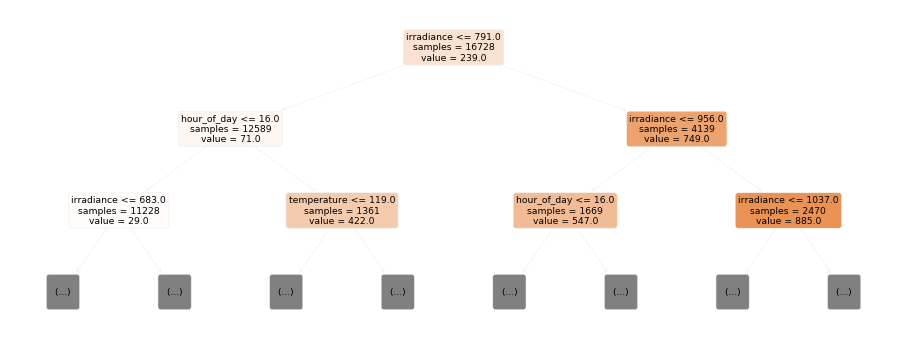

In [14]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(16, 6))
tree.plot_tree(optimised_random_forest,
               rounded=True, 
               max_depth=2, # The maximum depth of the representation. If None, the tree is fully generated.
               feature_names=X_train.columns,
               impurity=False,
               precision=0,
               filled=True)
fig.savefig('decision_tree.png')


### Model Performance

In [12]:
y_pred = pd.DataFrame(optimised_random_forest.predict(X_test))
y_pred.index = y_test.index

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MeAE:", median_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 3957.610576901414
MAE: 29.597197286466063
MeAE: 3.811614805554642
R2: 0.9640114497015726


### Plot Example

/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/nw_py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(737638.0, 737644.0)

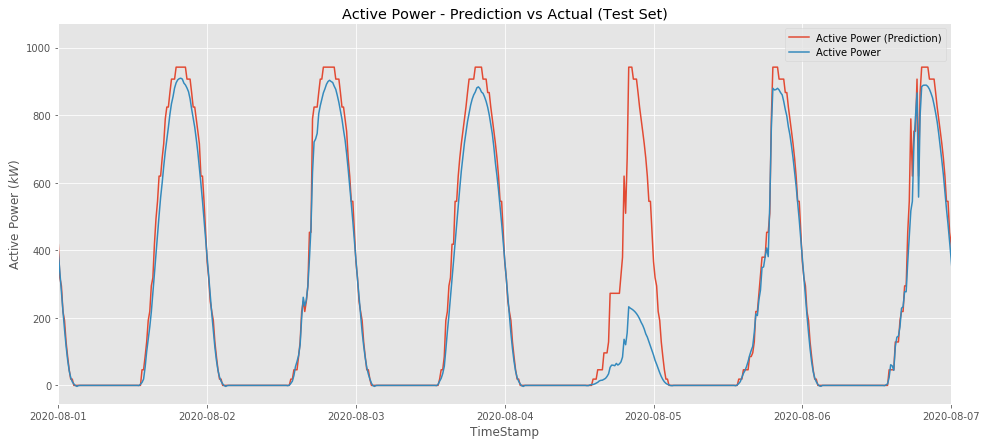

In [13]:
fig, ax = plt.subplots(figsize=(16,7))

test_timestamp = df.iloc[df_test.index]['timestamp']
plt.plot(test_timestamp, y_pred, label='Active Power (Prediction)')
plt.plot(test_timestamp, df_test[['active_power']], label='Active Power')

plt.title('Active Power - Prediction vs Actual (Test Set)')
plt.ylabel('Active Power ($kW$)')
plt.xlabel('TimeStamp')
plt.legend()
plt.xlim('2020-08-01','2020-08-07') # Show one month.